In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Load data ===
df = pd.read_csv("results/expanded_grid/summary.csv")

# === Mappings ===
mig_rate_map = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2,
    "very_high": 0.1
}
df["mig_rate_val"] = df["mig_rate"].map(mig_rate_map)

# === Output path ===
Path("figures/section_5_4").mkdir(parents=True, exist_ok=True)

# === Helper: Compute Power ===
def compute_power(df, metric, threshold, greater_than=True):
    result = []
    for mig in sorted(df["mig_rate"].unique(), key=lambda x: mig_rate_map[x]):
        subset = df[df["mig_rate"] == mig]
        if subset.empty or mig == "none":
            continue
        if greater_than:
            power = np.mean(subset[metric] > threshold)
        else:
            power = np.mean(np.abs(subset[metric]) > threshold)
        result.append((mig_rate_map[mig], power))
    return zip(*result)

# === 5.4.1 — Plot 1: Joint KDE under intermediate divergence ===
df_inter = df[df["divergence"] == "intermediate"]
plt.figure(figsize=(7, 6))
for mig in ["none", "moderate", "high", "very_high"]:
    sns.kdeplot(
        data=df_inter[df_inter["mig_rate"] == mig],
        x="FST_BC",
        y="D",
        fill=True,
        levels=5,
        alpha=0.6,
        label=mig
    )
plt.xlabel("FST (B vs C)")
plt.ylabel("D-statistic")
plt.title("Joint KDE: D vs. FST | Divergence: intermediate")
plt.legend(title="Migration Rate")
plt.tight_layout()
plt.savefig("figures/section_5_4/joint_kde_d_fst_intermediate.png", dpi=300)
plt.close()

# === 5.4.1 — Plot 2: Saturation of D and FST (intermediate, Ne=100000) ===
subset = df[(df["divergence"] == "intermediate") & (df["Ne"] == 100000)]
grouped = subset.groupby("mig_rate_val").agg({
    "D": "mean",
    "FST_BC": "mean"
}).sort_index()

plt.figure(figsize=(7, 5))
plt.plot(grouped.index, grouped["D"], marker='o', label="D-statistic", color="blue")
plt.plot(grouped.index, grouped["FST_BC"], marker='o', label="FST (B vs C)", color="firebrick")
plt.xscale("log")
plt.xlabel("Migration Rate")
plt.ylabel("Statistic Value")
plt.title("Mean D and FST vs. Migration Rate\n(intermediate divergence, Ne=100,000)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/section_5_4/saturation_plot.png", dpi=300)
plt.close()

# === 5.4.2 — Plot 3: Power curves (intermediate divergence) ===
div = "intermediate"
df_sub = df[df["divergence"] == div]
fst_thresh = df_sub[df_sub["mig_rate"] == "none"]["FST_BC"].quantile(0.95)
x_d, y_d = compute_power(df_sub, "D", threshold=0.2, greater_than=False)
x_f, y_f = compute_power(df_sub, "FST_BC", threshold=fst_thresh, greater_than=True)

plt.figure(figsize=(7, 5))
plt.plot(x_d, y_d, marker='o', label="D-statistic", color="blue")
plt.plot(x_f, y_f, marker='o', label="FST (B vs C)", color="darkred")
plt.xscale("log")
plt.ylim(0, 1.05)
plt.xlabel("Migration Rate")
plt.ylabel("Power (Detection Rate)")
plt.title("Power vs. Migration Rate | Divergence: intermediate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/section_5_4/power_curve_intermediate.png", dpi=300)
plt.close()

# === 5.4.2 — Plot 4: Power curves (ancient migration, Ne=500,000) ===
df_anc = df[
    (df["divergence"] == "ancient") &
    (df["Ne"] == 500000) &
    (df["mig_time"] == "ancient") &
    (df["mig_model"] == "episodic") &
    (df["mig_direction"] == "symmetric")
]
fst_thresh = df_anc[df_anc["mig_rate"] == "none"]["FST_BC"].quantile(0.95)
x_d, y_d = compute_power(df_anc, "D", threshold=0.2, greater_than=False)
x_f, y_f = compute_power(df_anc, "FST_BC", threshold=fst_thresh, greater_than=True)

plt.figure(figsize=(7, 5))
plt.plot(x_d, y_d, marker='o', label="D-statistic", color="blue")
plt.plot(x_f, y_f, marker='o', label="FST (B vs C)", color="darkred")
plt.xscale("log")
plt.ylim(0, 1.05)
plt.xlabel("Migration Rate")
plt.ylabel("Power (Detection Rate)")
plt.title("Power vs. Migration Rate | Ancient + Ne=500,000 (episodic, symmetric)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/section_5_4/power_curve_ancient.png", dpi=300)
plt.close()


/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72660/2321595746.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Migration Rate")


/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72705/180974669.py:32: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72705/180974669.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Migration Rate")


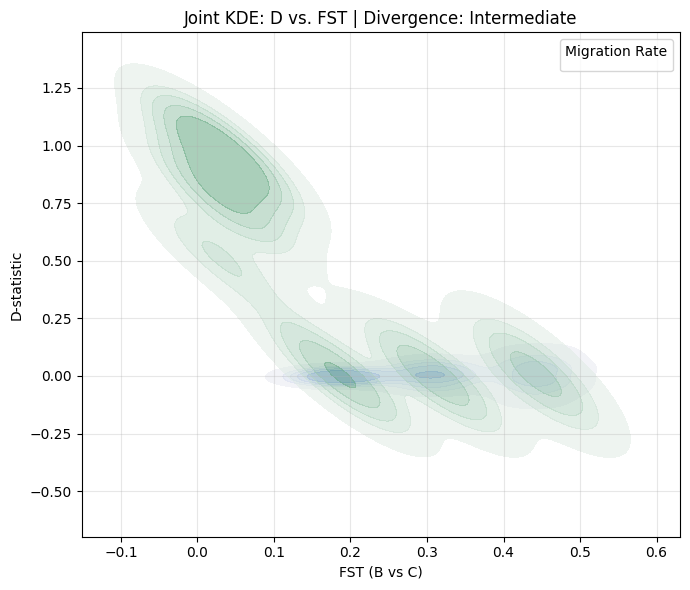

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Load data ===
df = pd.read_csv("results/expanded_grid/summary.csv")

# === Output path ===
Path("figures/section_5_4").mkdir(parents=True, exist_ok=True)

# === Filter for intermediate divergence ===
df_inter = df[df["divergence"] == "intermediate"]

# === Custom simplified migration set ===
mig_plot_order = ["none", "moderate", "super_high"]
color_map = {
    "none": "royalblue",
    "moderate": "seagreen",
    "super_high": "crimson"
}
label_map = {
    "none": "No Migration",
    "moderate": "Moderate",
    "super_high": "Super High"
}

# === Plot ===
plt.figure(figsize=(7, 6))
for mig in mig_plot_order:
    subset = df_inter[df_inter["mig_rate"] == mig]
    sns.kdeplot(
        data=subset,
        x="FST_BC",
        y="D",
        fill=True,
        levels=6,
        alpha=0.5,
        linewidths=1.2,
        cmap=sns.light_palette(color_map[mig], as_cmap=True),
        label=label_map[mig]
    )

# === Plot settings ===
plt.xlabel("FST (B vs C)")
plt.ylabel("D-statistic")
plt.title("Joint KDE: D vs. FST | Divergence: Intermediate")
plt.legend(title="Migration Rate")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/section_5_4/joint_kde_d_fst_intermediate_simplified.png", dpi=300)
plt.show()


/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72705/4152664570.py:30: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72705/4152664570.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Migration Rate")


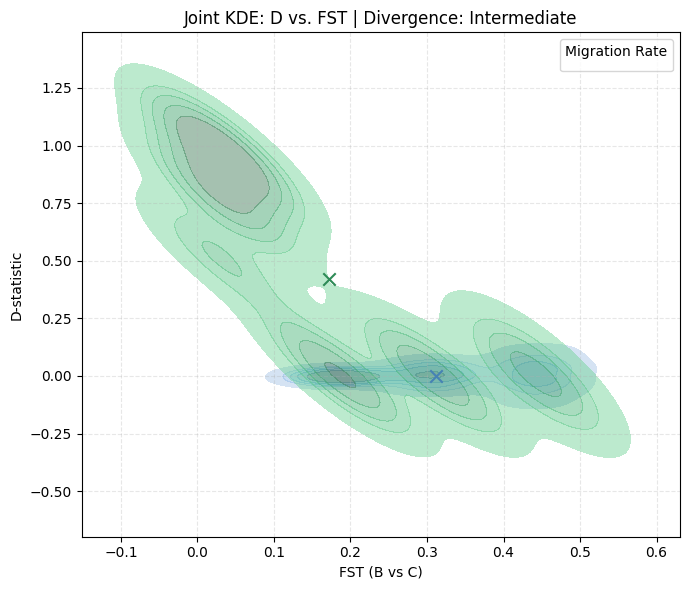

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Load data ===
df = pd.read_csv("results/expanded_grid/summary.csv")

# === Setup ===
Path("figures/section_5_4").mkdir(parents=True, exist_ok=True)
df_inter = df[df["divergence"] == "intermediate"]

# === Parameters ===
mig_plot_order = ["none", "moderate", "super_high"]
color_map = {
    "none": "steelblue",
    "moderate": "seagreen",
    "super_high": "crimson"
}
label_map = {
    "none": "No migration",
    "moderate": "Moderate migration",
    "super_high": "Super high migration"
}

# === Plot ===
plt.figure(figsize=(7, 6))
for mig in mig_plot_order:
    subset = df_inter[df_inter["mig_rate"] == mig]
    sns.kdeplot(
        data=subset,
        x="FST_BC",
        y="D",
        fill=True,
        levels=6,
        alpha=0.45,
        linewidths=1.2,
        color=color_map[mig],
        label=label_map[mig]
    )
    # Plot mean point for each migration rate
    mean_x = subset["FST_BC"].mean()
    mean_y = subset["D"].mean()
    plt.scatter(mean_x, mean_y, marker='x', s=80, color=color_map[mig], zorder=10)

# === Formatting ===
plt.xlabel("FST (B vs C)")
plt.ylabel("D-statistic")
plt.title("Joint KDE: D vs. FST | Divergence: Intermediate")
plt.legend(title="Migration Rate")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("figures/section_5_4/joint_kde_d_fst_intermediate_final.png", dpi=300)
plt.show()


In [2]:
# 4_Power_curves.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv("results/expanded_grid/summary.csv")

def compute_power(sub_df, metric, threshold, greater_than=True):
    power_data = []
    for mig_rate in sorted(sub_df["mig_rate"].unique()):
        subset = sub_df[sub_df["mig_rate"] == mig_rate]
        if greater_than:
            power = np.mean(subset[metric] > threshold)
        else:
            power = np.mean(np.abs(subset[metric]) > threshold)
        power_data.append((mig_rate, power))
    return power_data

Path("figures/expanded_power").mkdir(parents=True, exist_ok=True)

for div in df["divergence"].unique():
    for Ne in df["Ne"].unique():
        for mig_model in df["mig_model"].unique():
            for mig_direction in df["mig_direction"].unique():
                sub = df[
                    (df["divergence"] == div) &
                    (df["Ne"] == Ne) &
                    (df["mig_model"] == mig_model) &
                    (df["mig_direction"] == mig_direction)
                ]
                if sub.empty:
                    continue
                baseline_fst = sub[sub["mig_rate"] == "none"]["FST_BC"].quantile(0.95)
                d_thresh = 0.2

                power_d = compute_power(sub, "D", d_thresh, greater_than=False)
                power_fst = compute_power(sub, "FST_BC", baseline_fst, greater_than=True)

                plt.figure(figsize=(6, 5))
                x = [1e-6, 1e-4, 1e-2, 0.1]
                y_d = [v for k, v in power_d if k != "none"]
                y_fst = [v for k, v in power_fst if k != "none"]

                plt.plot(x, y_d, label="D-statistic", color="blue", marker="o")
                plt.plot(x, y_fst, label="FST (B vs C)", color="darkred", marker="o")

                plt.xscale("log")
                plt.ylim(0, 1.05)
                plt.title(f"Power vs Migration | {div} | Ne={Ne} | {mig_model} | {mig_direction}")
                plt.xlabel("Migration Rate")
                plt.ylabel("Power")
                plt.legend()
                plt.tight_layout()

                filename = f"figures/expanded_power/power_{div}_Ne{Ne}_{mig_model}_{mig_direction}.png"
                plt.savefig(filename, dpi=300)
                plt.close()


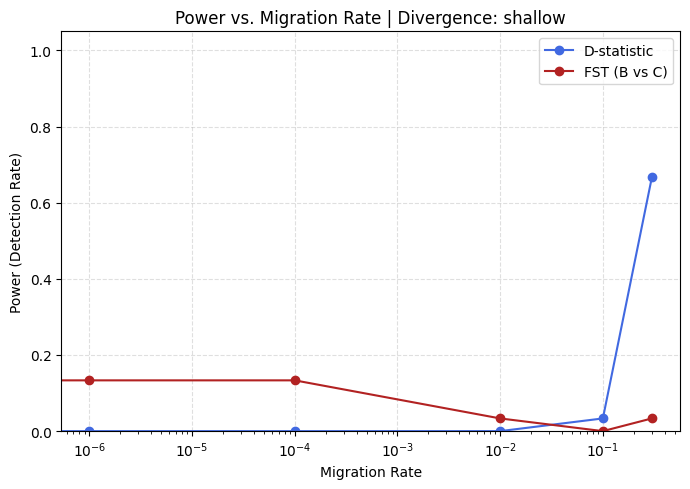

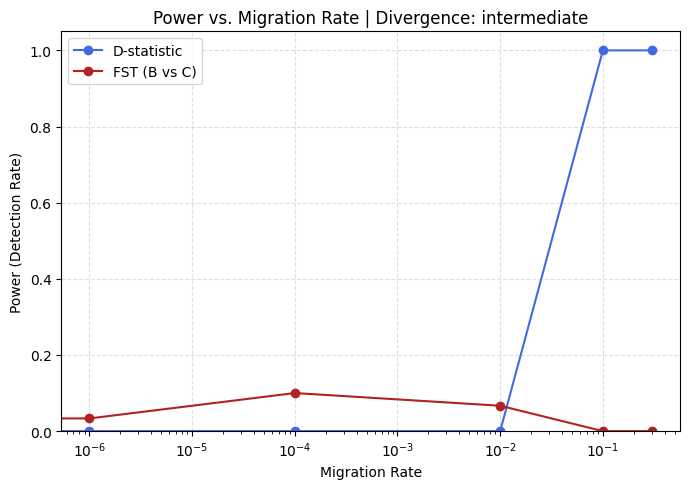

/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_56041/657654451.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


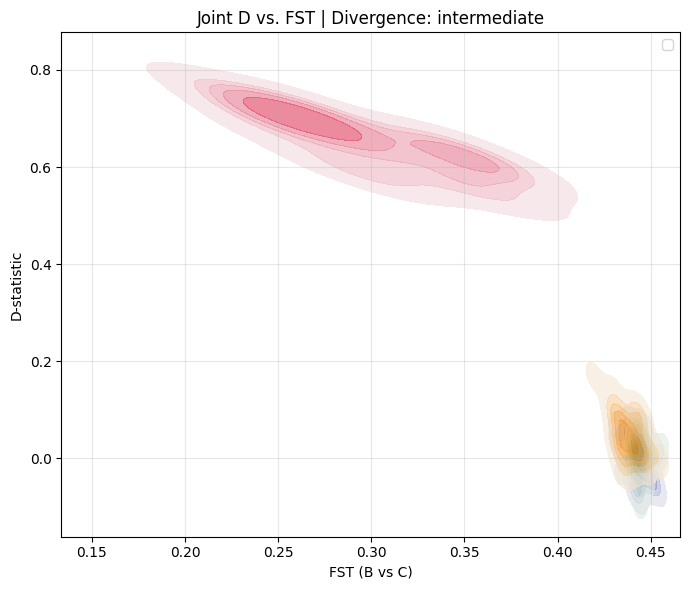

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Setup ===
Path("figures/power").mkdir(parents=True, exist_ok=True)

# === Load simulation data ===
df = pd.read_csv("results/mixed_updated/summary.csv")

# === Map mig_rate labels to numeric values ===
mig_rate_map = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2,
    "very_high": 0.1,
    "super_high": 0.3
}
df["mig_rate_val"] = df["mig_rate"].map(mig_rate_map)

# === Power Calculation Function ===
def compute_power(df, metric, threshold, greater_than=True):
    power_list = []
    for mig in sorted(df["mig_rate"].unique(), key=lambda x: mig_rate_map[x]):
        subset = df[df["mig_rate"] == mig]
        if greater_than:
            power = np.mean(subset[metric] > threshold)
        else:
            power = np.mean(np.abs(subset[metric]) > threshold)
        power_list.append({
            "mig_rate": mig,
            "mig_rate_val": mig_rate_map[mig],
            "power": power
        })
    return pd.DataFrame(power_list)

# === Generate Power Curves by Divergence ===
for div in df["divergence"].unique():
    sub = df[df["divergence"] == div]

    # Dynamically compute FST threshold from ILS-only (null) scenario
    fst_thresh = sub[sub["mig_rate"] == "none"]["FST_BC"].quantile(0.95)

    # Compute power for each stat
    power_d = compute_power(sub, "D", threshold=0.2, greater_than=False)
    power_fst = compute_power(sub, "FST_BC", threshold=fst_thresh, greater_than=True)

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(power_d["mig_rate_val"], power_d["power"], marker='o', label="D-statistic", color="royalblue")
    plt.plot(power_fst["mig_rate_val"], power_fst["power"], marker='o', label="FST (B vs C)", color="firebrick")
    plt.xlabel("Migration Rate")
    plt.ylabel("Power (Detection Rate)")
    plt.title(f"Power vs. Migration Rate | Divergence: {div}")
    plt.xscale("log")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"figures/power/power_vs_migration_{div}.png", dpi=300)
    plt.show()

# === Plot 2: Joint KDE of D vs. FST ===
def plot_joint_kde(df, mig_rate_values, labels, colors, divergence="intermediate"):
    plt.figure(figsize=(7, 6))
    for mig_label, display_label, color in zip(mig_rate_values, labels, colors):
        subset = df[(df["mig_rate"] == mig_label) & (df["divergence"] == divergence)]
        sns.kdeplot(
            x=subset["FST_BC"],
            y=subset["D"],
            cmap=sns.light_palette(color, as_cmap=True),
            fill=True,
            levels=6,
            alpha=0.6,
            linewidths=1.2,
            label=display_label
        )
    plt.xlabel("FST (B vs C)")
    plt.ylabel("D-statistic")
    plt.title(f"Joint D vs. FST | Divergence: {divergence}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/power/joint_d_fst_kde_{divergence}.png", dpi=300)
    plt.show()

# Run KDE plot for joint distribution
plot_joint_kde(
    df,
    mig_rate_values=["none", "moderate", "high", "super_high"],
    labels=["No Migration", "Moderate", "High", "Super High"],
    colors=["navy", "seagreen", "darkorange", "crimson"],
    divergence="intermediate"
)


/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72705/2484394685.py:50: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(mean_fst, mean_d, color=color, edgecolor='black', s=70, marker="x", zorder=10)
/Users/rachaelchew/Library/Python/3.9/lib/python/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_72705/2484394685.py:50: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(mean_fst, mea

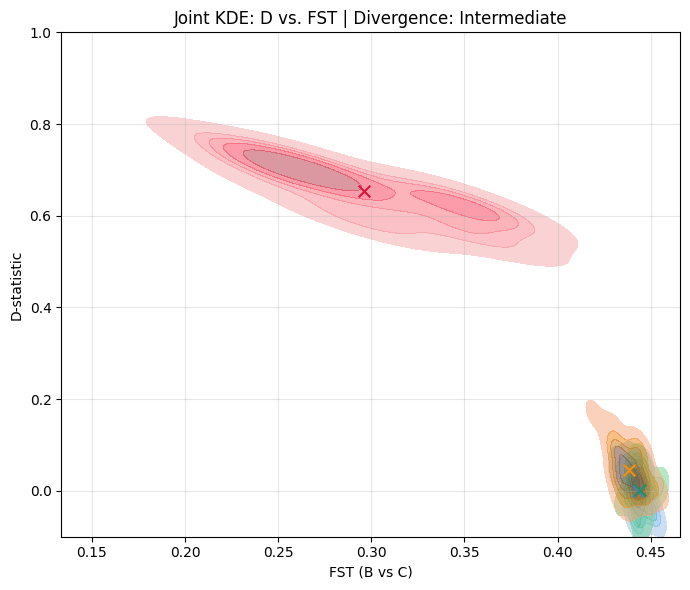

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Load data ===
df = pd.read_csv("results/mixed_updated/summary.csv")

# === Map mig_rate labels to numeric values ===
mig_rate_map = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2,
    "very_high": 0.1,
    "super_high": 0.3
}
df["mig_rate_val"] = df["mig_rate"].map(mig_rate_map)

# === Output folder ===
Path("figures/power").mkdir(parents=True, exist_ok=True)

# === Final KDE plot function ===
def plot_joint_kde_with_means(df, mig_rate_values, labels, colors, divergence="intermediate"):
    plt.figure(figsize=(7, 6))

    for mig_label, display_label, color in zip(mig_rate_values, labels, colors):
        subset = df[(df["mig_rate"] == mig_label) & (df["divergence"] == divergence)]
        
        # Skip empty subsets
        if subset.empty:
            continue

        # KDE contour
        sns.kdeplot(
            x=subset["FST_BC"],
            y=subset["D"],
            fill=True,
            levels=6,
            alpha=0.5,
            linewidths=1.2,
            label=display_label,
            color=color
        )

        # Mean marker (x)
        mean_fst = subset["FST_BC"].mean()
        mean_d = subset["D"].mean()
        plt.scatter(mean_fst, mean_d, color=color, edgecolor='black', s=70, marker="x", zorder=10)

    plt.xlabel("FST (B vs C)")
    plt.ylabel("D-statistic")
    plt.title(f"Joint KDE: D vs. FST | Divergence: {divergence.capitalize()}")
    plt.ylim(-0.1, 1.0)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"figures/power/joint_d_fst_kde_{divergence}.png", dpi=300)
    plt.show()

# === Run updated plot ===
plot_joint_kde_with_means(
    df,
    mig_rate_values=["none", "moderate", "high", "super_high"],
    labels=["No Migration", "Moderate", "High", "Super High"],
    colors=["steelblue", "seagreen", "darkorange", "crimson"],
    divergence="intermediate"
)


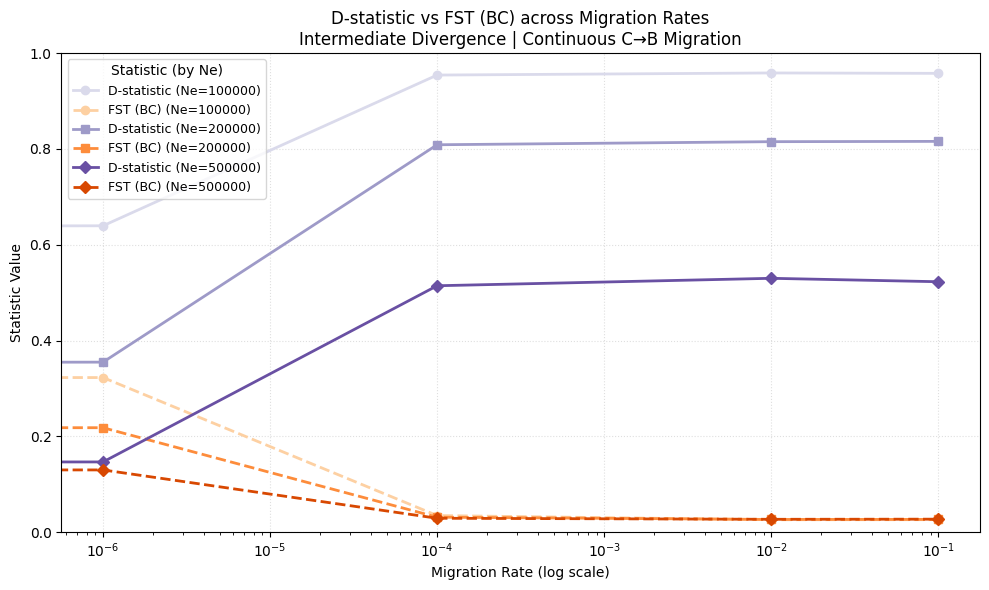

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load simulation summary ===
df = pd.read_csv("results/expanded_grid/summary.csv")

# === Filter: intermediate divergence, continuous, C→B migration ===
filtered = df[
    (df["divergence"] == "intermediate") &
    (df["mig_model"] == "continuous") &
    (df["mig_direction"] == "C_to_B")
].copy()

# === Map categorical mig_rate to numeric values ===
mig_rate_map = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2,
    "very_high": 1e-1
}
filtered["mig_rate_val"] = filtered["mig_rate"].map(mig_rate_map)

# === Group by Ne and migration rate ===
grouped = (
    filtered.groupby(["Ne", "mig_rate", "mig_rate_val"])
    .agg(
        mean_D=("D", "mean"),
        mean_FST_BC=("FST_BC", "mean")
    )
    .reset_index()
    .sort_values(by=["Ne", "mig_rate_val"])
)

# === Setup plot ===
plt.figure(figsize=(10, 6))
colors_d = sns.color_palette("Purples", n_colors=3)
colors_fst = sns.color_palette("Oranges", n_colors=3)
markers = ["o", "s", "D"]

# === Plot lines for each Ne ===
for i, ne in enumerate(sorted(grouped["Ne"].unique())):
    sub = grouped[grouped["Ne"] == ne]
    
    # Plot D-statistic
    plt.plot(
        sub["mig_rate_val"], sub["mean_D"],
        label=f"D-statistic (Ne={ne})",
        marker=markers[i],
        linestyle='-',
        linewidth=2,
        color=colors_d[i]
    )
    
    # Plot FST (BC)
    plt.plot(
        sub["mig_rate_val"], sub["mean_FST_BC"],
        label=f"FST (BC) (Ne={ne})",
        marker=markers[i],
        linestyle='--',
        linewidth=2,
        color=colors_fst[i]
    )

# === Plot formatting ===
plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("Migration Rate (log scale)")
plt.ylabel("Statistic Value")
plt.title("D-statistic vs FST (BC) across Migration Rates\nIntermediate Divergence | Continuous C→B Migration")
plt.legend(title="Statistic (by Ne)", fontsize=9)
plt.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.savefig("figures/final_insightful_plot_FIXED.png", dpi=300)
plt.show()


# Others

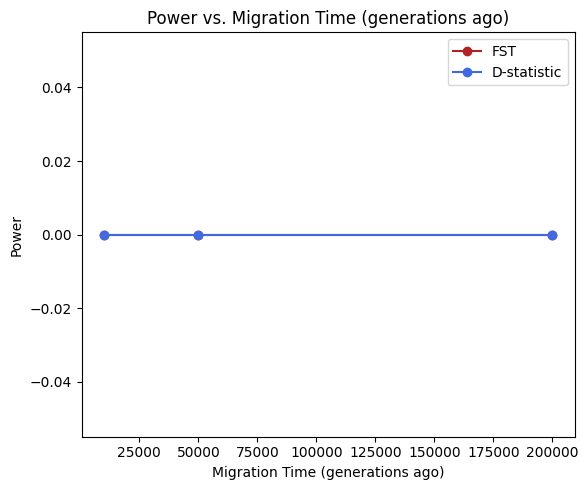

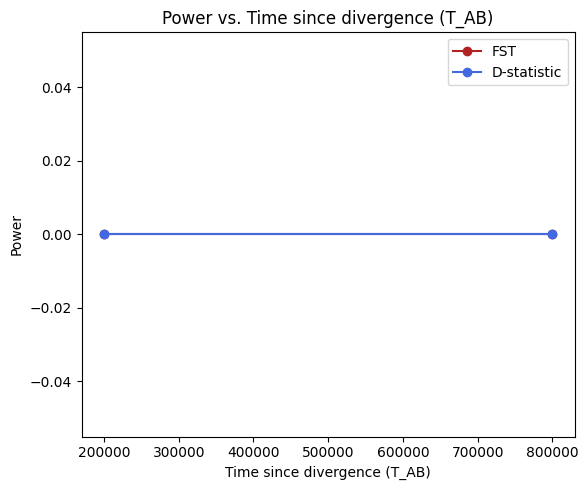

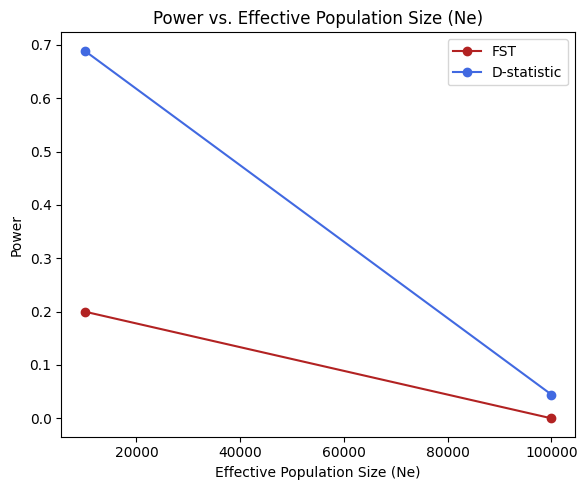

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Load data ===
project_root = Path("/Users/rachaelchew/Evolutionary-Genetics-Research")
df_mixed = pd.read_csv(project_root / "notebooks/results/mixed_updated/summary.csv")
df_ils = pd.read_csv(project_root / "results/fst_distributions/ils_only.csv")

# ✅ Clip FST_BC to avoid invalid values
df_ils["FST_BC"] = df_ils["FST_BC"].clip(lower=0, upper=1)
df_mixed["FST_BC"] = df_mixed["FST_BC"].clip(lower=0, upper=1)

# === Thresholds from ILS-only ===
FST_threshold = df_ils["FST_BC"].quantile(0.90)
D_threshold = df_ils["D"].quantile(0.80)
# === Parameter maps ===
mig_time_map = {"recent": 10000, "intermediate": 50000, "ancient": 200000}
div_map = {"shallow": 200000, "intermediate": 800000}
ne_map = {"small": 10000, "large": 100000}

# === Helper: Compute power ===
def compute_power(df, metric, threshold, group_col, group_val_map=None, greater_than=True):
    power_df = []
    for val in sorted(df[group_col].unique(), key=lambda x: group_val_map.get(x, x) if group_val_map else x):
        subset = df[df[group_col] == val]
        if greater_than:
            power = (subset[metric] > threshold).mean()
        else:
            power = (subset[metric].abs() > threshold).mean()
        power_df.append({
            group_col: val,
            "value": group_val_map[val] if group_val_map else val,
            "power": power
        })
    return pd.DataFrame(power_df)

# === Helper: Plot power ===
def plot_power(df_d, df_fst, xlab, outname):
    plt.figure(figsize=(6, 5))
    plt.plot(df_fst["value"], df_fst["power"], label="FST", color="firebrick", marker='o')
    plt.plot(df_d["value"], df_d["power"], label="D-statistic", color="royalblue", marker='o')
    plt.xlabel(xlab)
    plt.ylabel("Power")
    plt.title(f"Power vs. {xlab}")
    plt.legend()
    if all(isinstance(x, (float, int)) for x in df_fst["value"]):
        plt.xscale("log" if min(df_fst["value"]) < 0.01 else "linear")
    plt.tight_layout()
    plt.savefig(f"figures/power/power_vs_{outname}.png", dpi=300)
    plt.show()

# === 1. Power vs Migration Time ===
df_time = df_mixed[
    (df_mixed["mig_rate"] == "high") &
    (df_mixed["divergence"] == "intermediate")
]
power_d_time = compute_power(df_time, "D", D_threshold, "mig_time", mig_time_map, greater_than=False)
power_fst_time = compute_power(df_time, "FST_BC", FST_threshold, "mig_time", mig_time_map, greater_than=True)
plot_power(power_d_time, power_fst_time, "Migration Time (generations ago)", "migration_time")

# === 2. Power vs Divergence ===
df_div = df_mixed[
    (df_mixed["mig_rate"] == "high") &
    (df_mixed["mig_time"] == "intermediate")
]
power_d_div = compute_power(df_div, "D", D_threshold, "divergence", div_map, greater_than=False)
power_fst_div = compute_power(df_div, "FST_BC", FST_threshold, "divergence", div_map, greater_than=True)
plot_power(power_d_div, power_fst_div, "Time since divergence (T_AB)", "divergence")

# === 3. Power vs Ne ===
power_d_ne = compute_power(df_ils, "D", D_threshold, "Ne", ne_map, greater_than=False)
power_fst_ne = compute_power(df_ils, "FST_BC", FST_threshold, "Ne", ne_map, greater_than=True)
plot_power(power_d_ne, power_fst_ne, "Effective Population Size (Ne)", "Ne")


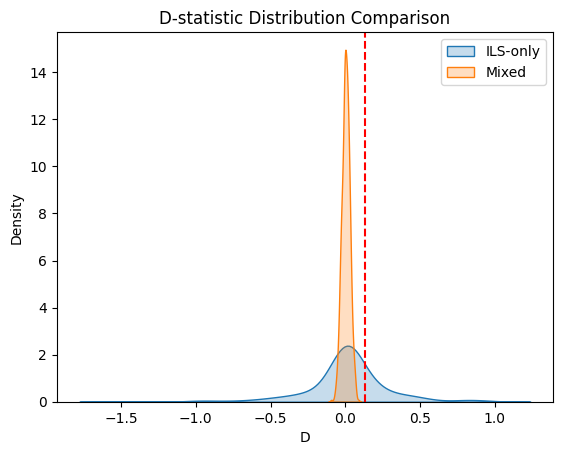

In [44]:
import seaborn as sns
sns.kdeplot(df_ils["D"], label="ILS-only", fill=True)
sns.kdeplot(df_mixed["D"], label="Mixed", fill=True)
plt.axvline(D_threshold, linestyle="--", color="red")
plt.title("D-statistic Distribution Comparison")
plt.xlabel("D")
plt.legend()
plt.show()

In [31]:
print(df_div.groupby("divergence")["FST_BC"].describe())


              count      mean       std       min       25%       50%  \
divergence                                                              
intermediate   30.0  0.303718  0.004031  0.294391  0.300784  0.305237   
shallow        30.0  0.134828  0.002495  0.130048  0.133121  0.134989   

                   75%       max  
divergence                        
intermediate  0.306844  0.308647  
shallow       0.136191  0.140208  


In [17]:
print("FST threshold:", FST_threshold)
print("Max FST_BC:", df_mixed["FST_BC"].max())
print("Unique mig_time in high migration subset:", df_mixed[df_mixed["mig_rate"] == "high"]["mig_time"].unique())
print("Unique divergence in high migration subset:", df_mixed[df_mixed["mig_rate"] == "high"]["divergence"].unique())

FST threshold: 0.6578075395913087
Max FST_BC: 0.3194243482757095
Unique mig_time in high migration subset: ['recent' 'intermediate' 'ancient']
Unique divergence in high migration subset: ['shallow' 'intermediate']


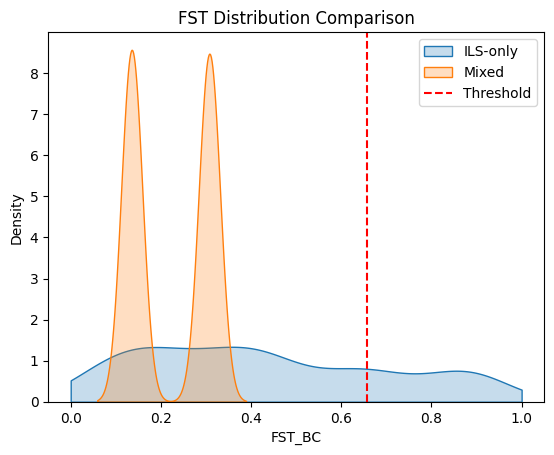

In [22]:
import seaborn as sns
sns.kdeplot(df_ils["FST_BC"], fill=True, label="ILS-only", clip=(0, 1))
sns.kdeplot(df_mixed["FST_BC"], fill=True, label="Mixed", clip=(0, 1))
plt.axvline(FST_threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("FST_BC")
plt.title("FST Distribution Comparison")
plt.legend()
plt.show()

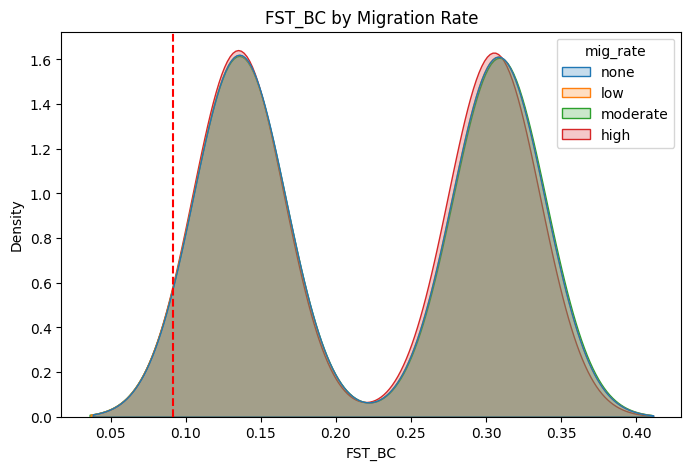

In [26]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_mixed, x="FST_BC", hue="mig_rate", fill=True)
plt.title("FST_BC by Migration Rate")
plt.axvline(FST_threshold, linestyle="--", color="red")
plt.show()


[INFO] Power vs. Migration Rate for divergence = shallow
[INFO] D threshold: 0.4367
[INFO] FST threshold: 0.0965


/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_43660/943230897.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[metric_fst] = df_target[metric_fst].clip(*clip_range)


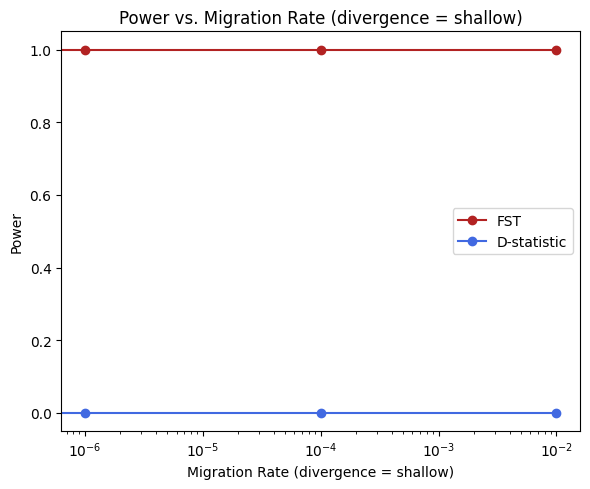


[INFO] Power vs. Migration Rate for divergence = intermediate
[INFO] D threshold: 0.4367
[INFO] FST threshold: 0.0965


/var/folders/rt/dyvzjjbj3ln8dp3pv22vc9740000gn/T/ipykernel_43660/943230897.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target[metric_fst] = df_target[metric_fst].clip(*clip_range)


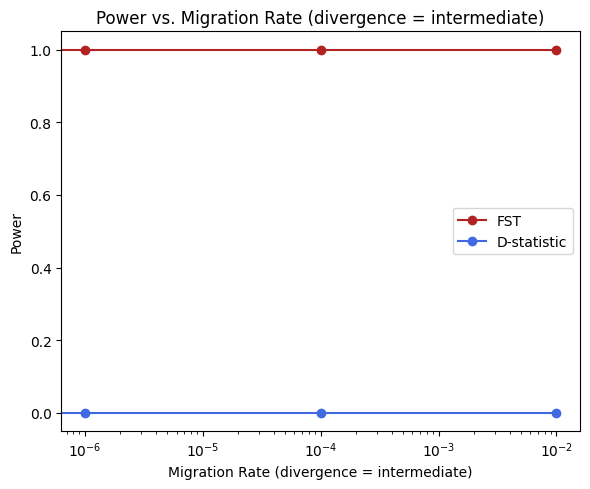

In [60]:
# === Define helper again if not already defined ===
def compute_power(df, metric, threshold, group_col, group_val_map=None, greater_than=True):
    power_df = []
    for val in sorted(df[group_col].unique(), key=lambda x: group_val_map.get(x, x) if group_val_map else x):
        subset = df[df[group_col] == val]
        if greater_than:
            power = (subset[metric] > threshold).mean()
        else:
            power = (subset[metric].abs() > threshold).mean()
        power_df.append({
            group_col: val,
            "value": group_val_map[val] if group_val_map else val,
            "power": power
        })
    return pd.DataFrame(power_df)

def plot_power(df_d, df_fst, xlab, outname):
    plt.figure(figsize=(6, 5))
    plt.plot(df_fst["value"], df_fst["power"], label="FST", color="firebrick", marker='o')
    plt.plot(df_d["value"], df_d["power"], label="D-statistic", color="royalblue", marker='o')
    plt.xlabel(xlab)
    plt.ylabel("Power")
    plt.title(f"Power vs. {xlab}")
    plt.legend()
    if all(isinstance(x, (float, int)) for x in df_fst["value"]):
        plt.xscale("log" if min(df_fst["value"]) < 0.01 else "linear")
    plt.tight_layout()
    plt.savefig(f"figures/power/power_vs_{outname}.png", dpi=300)
    plt.show()

def sweep_and_plot_power(
    df_target,
    ils_df,
    metric_d="D",
    metric_fst="FST_BC",
    group_col="mig_rate",
    group_val_map=None,
    outname="migration_rate",
    xlab="Migration Rate",
    FST_threshold=None,
    D_threshold=None,
    clip_range=(0, 1)
):
    # Step 1: Clip
    df_target[metric_fst] = df_target[metric_fst].clip(*clip_range)
    ils_df[metric_fst] = ils_df[metric_fst].clip(*clip_range)

    # Step 2: Thresholds
    if FST_threshold is None:
        FST_threshold = ils_df[metric_fst].quantile(0.15)
    if D_threshold is None:
        D_threshold = ils_df[metric_d].quantile(0.95)

    print(f"[INFO] D threshold: {D_threshold:.4f}")
    print(f"[INFO] FST threshold: {FST_threshold:.4f}")

    # Step 3: Compute power
    df_d = compute_power(df_target, metric_d, D_threshold, group_col, group_val_map, greater_than=False)
    df_fst = compute_power(df_target, metric_fst, FST_threshold, group_col, group_val_map, greater_than=True)

    # Step 4: Plot
    plot_power(df_d, df_fst, xlab, outname)

# === Migration Rate Map ===
mig_rate_map = {"none": 0.0, "low": 1e-6, "moderate": 1e-4, "high": 1e-2}

# === Run sweep for each divergence level ===
divergence_levels = ["shallow", "intermediate"]

for div in divergence_levels:
    df_subset = df_mixed[df_mixed["divergence"] == div]

    print(f"\n[INFO] Power vs. Migration Rate for divergence = {div}")

    sweep_and_plot_power(
        df_target=df_subset,
        ils_df=df_ils,
        group_col="mig_rate",
        group_val_map=mig_rate_map,
        outname=f"migration_rate_div_{div}",
        xlab=f"Migration Rate (divergence = {div})"
    )


In [46]:
print(df_mixed["D"].describe())

count    720.000000
mean       0.002500
std        0.026427
min       -0.093576
25%       -0.014619
50%        0.002437
75%        0.020947
max        0.087742
Name: D, dtype: float64


In [47]:
print(df_mixed.head(10))

   rep divergence mig_time mig_rate         D         ABBA         BABA  \
0    0    shallow   recent     none -0.019800  1302.577125  1355.202125   
1    1    shallow   recent     none  0.008266  1342.024750  1320.019750   
2    2    shallow   recent     none  0.014100  1253.361250  1218.508750   
3    3    shallow   recent     none  0.015195  1282.271500  1243.886500   
4    4    shallow   recent     none -0.009621  1200.378875  1223.701375   
5    5    shallow   recent     none  0.025328  1328.924500  1263.269500   
6    6    shallow   recent     none -0.013984  1340.338250  1378.355750   
7    7    shallow   recent     none  0.012182  1381.094000  1347.849000   
8    8    shallow   recent     none  0.024945  1389.018250  1321.405750   
9    9    shallow   recent     none -0.002654  1310.807375  1317.784875   

     FST_AB    FST_BC  
0  0.136266  0.135183  
1  0.134307  0.134581  
2  0.134118  0.136223  
3  0.134691  0.135758  
4  0.129943  0.135877  
5  0.133298  0.135707  
6  0.1

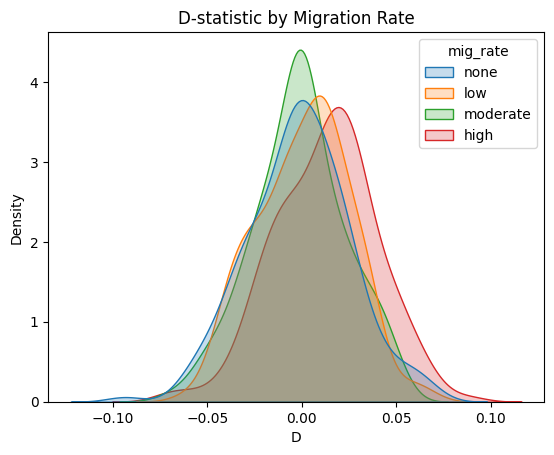

In [48]:
import seaborn as sns
sns.kdeplot(data=df_mixed, x="D", hue="mig_rate", fill=True)
plt.title("D-statistic by Migration Rate")
plt.show()

# Investigating why the D-statistic power is low


In [59]:
import sys
import os

# Add the `simulations` directory to your path
project_root = "/Users/rachaelchew/Evolutionary-Genetics-Research"
simulations_path = os.path.join(project_root, "simulations")

if simulations_path not in sys.path:
    sys.path.insert(0, simulations_path)

from common_utils import simulate_introgression_scenario, calculate_d_statistic

ts = simulate_introgression_scenario(
    Ne=200000,
    div_time_ab=200000,
    div_time_abc=400000,
    mig_rate=0.5,  # Force strong signal
    mig_time=10000,
    continuous=False,
    migration_direction="C_to_B"
)

d, abba, baba = calculate_d_statistic(ts)
print("D:", d)
print("ABBA:", abba)
print("BABA:", baba)


D: 0.5946872292174368
ABBA: 2503.5913750001705
BABA: 636.3238749999962


In [4]:
# === Sliding Window D-statistic ===
mids, d_stats = sliding_window_d(ts_example)

plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='navy', label="D-statistic")
plt.axhline(0, color='red', linestyle='--', label="D = 0")
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)

d_margin = 0.05 * (max(d_stats) - min(d_stats)) if d_stats else 0.01
plt.ylim(min(d_stats) - d_margin, max(d_stats) + d_margin)

plt.title("Sliding Window D-statistic | Genomic Heterogeneity")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mixed_updated/sliding_d_heterogeneity.png", dpi=300)
plt.show()


NameError: name 'sliding_window_d' is not defined